In [16]:
import numpy as np
import matplotlib.pyplot as plt
from gco import pygco
import cv2
import os

In [17]:
def parse_vector(file):
    components = file.readline().split()
    return np.array([float(x) for x in components], dtype=np.float32)

def parse_matrix(file):
    row1 = parse_vector(file)
    row2 = parse_vector(file)
    row3 = parse_vector(file)
    return np.matrix([row1, row2, row3], dtype=np.float32)

In [18]:
with open('cameras.txt', 'r') as file:
    num_frames = int(file.readline())
    file.readline()

    K = [None] * num_frames
    R = [None] * num_frames
    T = [None] * num_frames

    for i in range(num_frames):
        K[i] = parse_matrix(file)
        R[i] = parse_matrix(file)
        T[i] = np.asmatrix(parse_vector(file))
        file.readline()
        file.readline()
    

In [19]:
i1=cv2.imread('test0100.jpg')
a=cv2.imread('test0101.jpg')
b=cv2.imread('test0102.jpg')
c=cv2.imread('test0103.jpg')
d=cv2.imread('test0104.jpg')
e=cv2.imread('test0105.jpg')
f=cv2.imread('test0106.jpg')
g=cv2.imread('test0107.jpg')
h=cv2.imread('test0108.jpg')
img = []
img.append(np.float32(i1))
img.append(np.float32(a))
img.append(np.float32(b))
img.append(np.float32(c))
img.append(np.float32(d))
img.append(np.float32(e))
img.append(np.float32(f))
img.append(np.float32(g))
img.append(np.float32(h))
print(img[0].shape)
H,W,D = img[0].shape
disparity = np.arange(0,0.02,0.02/65)
d_num = len(disparity)

(540, 960, 3)


In [20]:
def create_homogeneous_coordinates_grid(height, width):
    X, Y = np.float32(np.meshgrid(np.arange(width, dtype=np.float32), np.arange(height, dtype=np.float32), indexing='xy'))
    X, Y, Z = (np.expand_dims(X, axis=0), np.expand_dims(Y, axis=0), np.ones([1, height, width], np.float32))
    return np.concatenate([X, Y, Z], axis=0)


In [21]:
image1 = img[0]
xh = create_homogeneous_coordinates_grid(H,W)
num_frame = 8
h, w = H,W
d = np.zeros([H, W], dtype=np.float32) #[h, w]
L = np.zeros([d_num, H, W], dtype=np.float32) #[d_numbers, h, w]


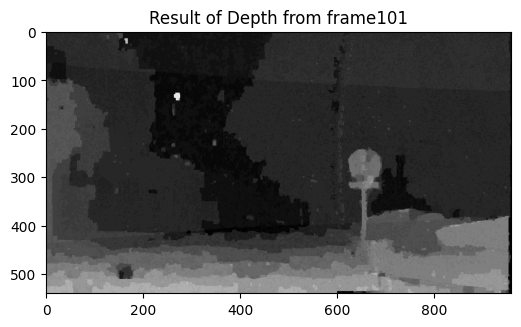

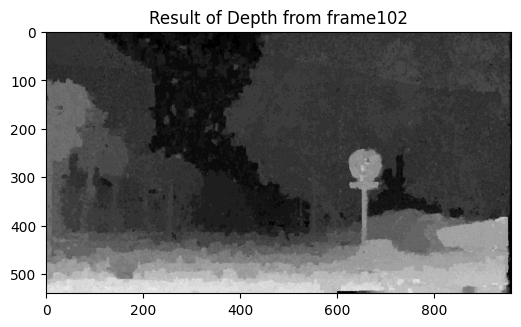

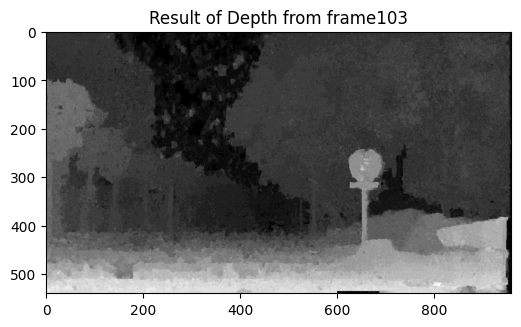

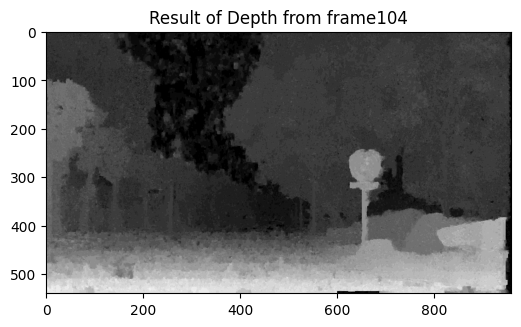

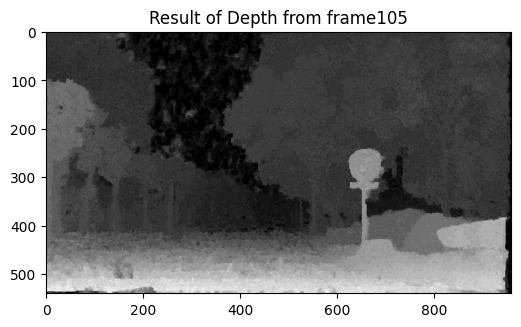

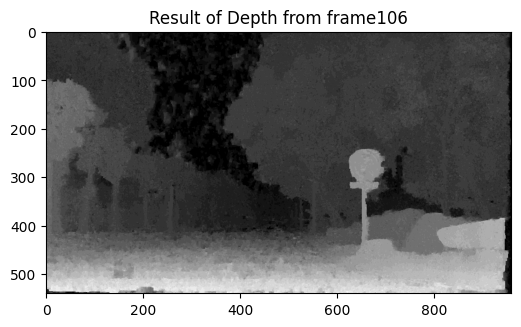

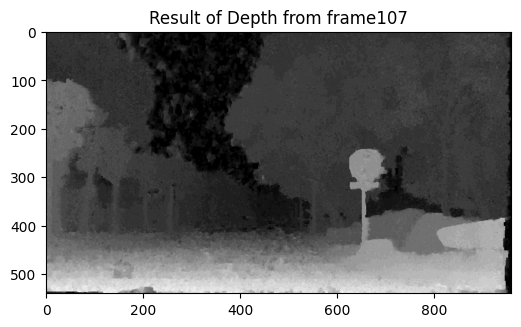

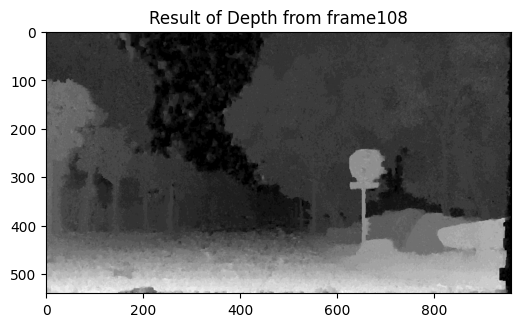

In [22]:
sequence = np.array([101,102,103,104,105,106,107,108])
for i in range (num_frame):
    I_temp = img[i+1]
    frame = sequence[i]
    for d_num in range(d_num):
        d[:,:] = disparity[d_num]
        xh = np.reshape(xh,[3,-1])
        d = np.reshape(d,[1,-1])
        depth = (T[100]-T[frame]).T * d 
        xhp = (K[100]*R[frame].T) * ((R[100]*K[100].I) * xh + depth)
        xhp = np.divide(xhp, xhp[2, :])
        xhp = np.reshape(np.asarray(xhp), [3, h, w])
        
        xp = np.transpose(xhp[:2,:,:],[1,2,0])
        
        Ip = cv2.remap(src = I_temp,map1=xp,map2=None,interpolation=cv2.INTER_NEAREST,borderValue=[128,128,128])
        sub = image1-Ip
        dis = np.sqrt(np.sum(np.square(sub),axis=-1,keepdims=True))
        tmp = 1.0/(1.0+dis)
        L[d_num,:,:] = L[d_num,:,:]+tmp[:,:,0]
        
    rec = np.reciprocal(L.max(axis=0, keepdims=True))    
    aa= 1 - rec*L
    precut=np.zeros((H,W,d_num))
    for k in range(d_num):
        precut[:,:,k] = aa[k,:,:]
    
    s = np.zeros((d_num,d_num))
    for n in range(d_num):
        for m in range(d_num):
            if n!=m:
                s[n][m] = min(abs(n-m),10)
    
    final = pygco.cut_grid_graph_simple(precut,s*0.1,connect=2,n_iter=-1)
    final = final.reshape(H,W)

    plt.figure(num=1, dpi=100, figsize=(6,6))
    plt.imshow(final,cmap='gray')
    plt.title(f'Result of Depth from frame{sequence[i]}')
    plt.show()